# Bibliotecas

In [1]:
import pyedflib
import numpy as np
import pandas as pd
import commands
import pywt
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from pywt import WaveletPacket
import pywt.data
from detect_peaks import detect_peaks
import os
from sys import platform
%matplotlib notebook

---

## Filtros

In [2]:
def FilterSignal(emg, low_pass=10., sfreq=2000., high_band=2., low_band=500.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    #return emg_envelope
    return emg_filtered

## Função Plot FFT

In [3]:
def PlotFft(Xc, F):
    #Xc = dfn['Ch1']
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    X = np.abs(np.fft.fft(Xc[:, 0]))
    fs = np.linspace(0, F,Xc[:, 0].shape[0])
    ax1.plot(fs,X, linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 1]))
    fs = np.linspace(0, F,Xc[:, 1].shape[0])
    ax2.plot(fs,X, linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 2]))
    fs = np.linspace(0, F,Xc[:, 2].shape[0])
    ax3.plot(fs,X, linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 3]))
    fs = np.linspace(0, F,Xc[:, 3].shape[0])
    ax4.plot(fs,X, linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função Plot

In [4]:
def PlotFile(dfn):
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    ax1.plot(dfn['Ch1'][2000:], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax2.plot(dfn['Ch2'][2000:], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax3.plot(dfn['Ch3'][2000:], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax4.plot(dfn['Ch4'][2000:], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função RMS

In [5]:
def Rms(file_):

    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    #Lê dados dos arquivos .edf
    #file_name = pyedflib.EdfReader('db/'+file_+'.edf')    
    #n = file_name.signals_in_file
    #signal_labels = file_name.getSignalLabels()
    #sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    #for j in np.arange(n):
    #     sigbufs[j, :] = file_name.readSignal(j)

    #file_name._close()

   # df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    Xc = np.load('db/partitioned/'+file_)

    df = pd.DataFrame(Xc)
    
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    return rms

---

In [9]:
if platform == "linux" or platform == "linux2":
    files = os.listdir('db/pure')
elif platform == "win32":
    files = os.listdir('C:\Users\jorge.junior\Documents\GitHub\PKS\db\pure')
        

def sectioner(file_):

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('db/pure/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)
    file_name._close()
    
    suf = 0
    Xc = np.transpose(sigbufs)
    qtd_div = 3
    brk_div = len(Xc)/qtd_div
    
    for i in range(0,qtd_div*brk_div,brk_div):
        suf += 1
        np.save('./db/partitioned/'+file_[:-3]+str(suf), Xc[i:i+brk_div], allow_pickle=False)

for i in files:
    sectioner(i)

## Calcula a Norma de cada canal

In [10]:
if platform == "linux" or platform == "linux2":
    files = os.listdir('db/partitioned')
elif platform == "win32":
    files = os.listdir('C:\Users\jorge.junior\Documents\GitHub\PKS\db\partitioned')

#Set validação
#files = ['prv06.3', 'prv07.2', 'prv09.3', 'prv17.3']

peaks_rms = [ ]
norm = [ ]


def Norm(file_):
    
    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)  

    #Lê dados dos arquivos .edf
    #file_name = pyedflib.EdfReader('db/'+file_+'.edf')    
    #n = file_name.signals_in_file
    #signal_labels = file_name.getSignalLabels()
    #sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    #for j in np.arange(n):
    #     sigbufs[j, :] = file_name.readSignal(j)

    #file_name._close()
    
    Xc = np.load('db/partitioned/'+file_)

    df = pd.DataFrame(Xc)
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rmslll
    peaks_rms.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),max(rms['Ch4']),])

#Cria a lista de picos RMS máximo    
for i in files:
    Norm(i)

#Calcula o máximo global
peaks_rms = pd.DataFrame(data=peaks_rms, columns=['Ch1','Ch2','Ch3','Ch4'])
norm = [max(peaks_rms['Ch1']),max(peaks_rms['Ch2']),max(peaks_rms['Ch3']),max(peaks_rms['Ch4'])]  

print 'Norma de cada canal: \n',norm

Norma de cada canal: 
[263.89182144080729, 384.35612169427225, 661.98840486337019, 218.64265844917927]


---

In [11]:
files

['pr09.2.3.npy',
 'prv06.3.2.npy',
 'piv17.3.2.npy',
 'pr17.2.2.npy',
 'prv09.3.2.npy',
 'pr17.1.2.npy',
 'piv09.2.2.npy',
 'piv09.2.3.npy',
 'pi17.1.3.npy',
 'pi09.1.3.npy',
 'pr17.2.3.npy',
 'pr06.1.3.npy',
 'pr07.1.3.npy',
 'pr09.1.3.npy',
 'pi09.1.2.npy',
 'prv17.3.2.npy',
 'piv09.2.1.npy',
 'piv07.3.3.npy',
 'prv07.2.3.npy',
 'prv09.3.3.npy',
 'pr17.1.3.npy',
 'prv17.3.3.npy',
 'piv07.3.1.npy',
 'prv07.2.2.npy',
 'piv06.2.3.npy',
 'pi07.2.3.npy',
 'pr06.2.2.npy',
 'prv09.3.1.npy',
 'pi06.1.3.npy',
 'piv06.2.1.npy',
 'piv17.3.1.npy',
 'pr09.2.1.npy',
 'pr07.1.1.npy',
 'prv06.3.1.npy',
 'piv17.3.3.npy',
 'prv06.3.3.npy',
 'pi07.2.2.npy',
 'pr09.2.2.npy',
 'prv17.3.1.npy',
 'pi06.1.2.npy',
 'piv07.3.2.npy',
 'pr07.1.2.npy',
 'pr06.2.1.npy',
 'pi09.1.1.npy',
 'pr17.1.1.npy',
 'pr06.1.1.npy',
 'pr06.1.2.npy',
 'pi17.1.2.npy',
 'pr09.1.1.npy',
 'piv06.2.2.npy',
 'pr06.2.3.npy',
 'pi17.1.1.npy',
 'pr17.2.1.npy',
 'pi06.1.1.npy',
 'prv07.2.1.npy',
 'pi07.2.1.npy',
 'pr09.1.2.npy']

## Aplica a norma em cada amostra e salva

In [12]:
def Std(file_):

    #Lê dados dos arquivos .edf
    #file_name = pyedflib.EdfReader('db/'+file_+'.edf')    
    #n = file_name.signals_in_file
    #signal_labels = file_name.getSignalLabels()
    #sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    #for j in np.arange(n):
    #     sigbufs[j, :] = file_name.readSignal(j)

    #file_name._close()

    #df = pd.DataFrame(np.transpose(sigbufs))
    
    Xc = np.load('db/partitioned/'+file_)

    df = pd.DataFrame(Xc)
    dfa = df.as_matrix()
    
    #Aplica a norma em cada canal
    Xc=np.array([dfa[:,0]/norm[0],dfa[:,1]/norm[1],dfa[:,2]/norm[2],dfa[:,3]/norm[3]])
    Xc = np.transpose(Xc)
    #Salva o arquivo normalizado na pasta <preproc>
    np.save('./preproc/'+file_[:-4]+'_std', Xc, allow_pickle=False)
    print file_[:-4]+'_std.npy'
    
    return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3','Ch4']))

In [13]:
for i in files:
    Std(i)

pr09.2.3_std.npy
prv06.3.2_std.npy
piv17.3.2_std.npy
pr17.2.2_std.npy
prv09.3.2_std.npy
pr17.1.2_std.npy
piv09.2.2_std.npy
piv09.2.3_std.npy
pi17.1.3_std.npy
pi09.1.3_std.npy
pr17.2.3_std.npy
pr06.1.3_std.npy
pr07.1.3_std.npy
pr09.1.3_std.npy
pi09.1.2_std.npy
prv17.3.2_std.npy
piv09.2.1_std.npy
piv07.3.3_std.npy
prv07.2.3_std.npy
prv09.3.3_std.npy
pr17.1.3_std.npy
prv17.3.3_std.npy
piv07.3.1_std.npy
prv07.2.2_std.npy
piv06.2.3_std.npy
pi07.2.3_std.npy
pr06.2.2_std.npy
prv09.3.1_std.npy
pi06.1.3_std.npy
piv06.2.1_std.npy
piv17.3.1_std.npy
pr09.2.1_std.npy
pr07.1.1_std.npy
prv06.3.1_std.npy
piv17.3.3_std.npy
prv06.3.3_std.npy
pi07.2.2_std.npy
pr09.2.2_std.npy
prv17.3.1_std.npy
pi06.1.2_std.npy
piv07.3.2_std.npy
pr07.1.2_std.npy
pr06.2.1_std.npy
pi09.1.1_std.npy
pr17.1.1_std.npy
pr06.1.1_std.npy
pr06.1.2_std.npy
pi17.1.2_std.npy
pr09.1.1_std.npy
piv06.2.2_std.npy
pr06.2.3_std.npy
pi17.1.1_std.npy
pr17.2.1_std.npy
pi06.1.1_std.npy
prv07.2.1_std.npy
pi07.2.1_std.npy
pr09.1.2_std.npy


In [14]:
Std('pr17.2.1.npy').head()

pr17.2.1_std.npy


,Ch1,Ch2,Ch3,Ch4
0,-0.018910,0.016194,0.007139,-0.020582
1,0.039959,0.053964,0.007139,-0.020582
2,0.029255,0.008640,0.007139,-0.013893
3,0.029255,0.004863,0.000575,-0.020582
4,0.002497,0.004863,0.000575,-0.040649


In [15]:
c = np.load('preproc/pr17.2.1_std.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,-0.018910,0.016194,0.007139,-0.020582
1,0.039959,0.053964,0.007139,-0.020582
2,0.029255,0.008640,0.007139,-0.013893
3,0.029255,0.004863,0.000575,-0.020582
4,0.002497,0.004863,0.000575,-0.040649


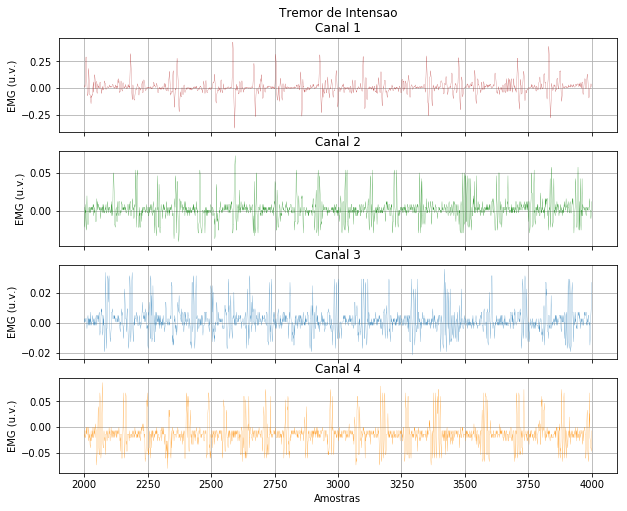

In [16]:
PlotFile(dfn)

In [17]:
for i in files:
    Xc = Rms(i)
    np.save('./preproc/'+i[:-4]+'_rms', Xc, allow_pickle=False)
    print i[:-4]+'_rms.npy'

pr09.2.3_rms.npy
prv06.3.2_rms.npy
piv17.3.2_rms.npy
pr17.2.2_rms.npy
prv09.3.2_rms.npy
pr17.1.2_rms.npy
piv09.2.2_rms.npy
piv09.2.3_rms.npy
pi17.1.3_rms.npy
pi09.1.3_rms.npy
pr17.2.3_rms.npy
pr06.1.3_rms.npy
pr07.1.3_rms.npy
pr09.1.3_rms.npy
pi09.1.2_rms.npy
prv17.3.2_rms.npy
piv09.2.1_rms.npy
piv07.3.3_rms.npy
prv07.2.3_rms.npy
prv09.3.3_rms.npy
pr17.1.3_rms.npy
prv17.3.3_rms.npy
piv07.3.1_rms.npy
prv07.2.2_rms.npy
piv06.2.3_rms.npy
pi07.2.3_rms.npy
pr06.2.2_rms.npy
prv09.3.1_rms.npy
pi06.1.3_rms.npy
piv06.2.1_rms.npy
piv17.3.1_rms.npy
pr09.2.1_rms.npy
pr07.1.1_rms.npy
prv06.3.1_rms.npy
piv17.3.3_rms.npy
prv06.3.3_rms.npy
pi07.2.2_rms.npy
pr09.2.2_rms.npy
prv17.3.1_rms.npy
pi06.1.2_rms.npy
piv07.3.2_rms.npy
pr07.1.2_rms.npy
pr06.2.1_rms.npy
pi09.1.1_rms.npy
pr17.1.1_rms.npy
pr06.1.1_rms.npy
pr06.1.2_rms.npy
pi17.1.2_rms.npy
pr09.1.1_rms.npy
piv06.2.2_rms.npy
pr06.2.3_rms.npy
pi17.1.1_rms.npy
pr17.2.1_rms.npy
pi06.1.1_rms.npy
prv07.2.1_rms.npy
pi07.2.1_rms.npy
pr09.1.2_rms.npy


In [18]:
c = np.load('preproc/pr17.2.1_rms.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,31.433966,11.005618,3.814996,4.568941
1,31.472225,11.005618,3.759033,4.544749
2,31.437055,10.643981,3.708176,4.520429
3,31.464284,10.633780,3.647849,4.520429
4,31.453254,10.651898,3.647849,4.475436


In [19]:
Rms('pr17.2.1.npy').head()

,Ch1,Ch2,Ch3,Ch4
0,31.433966,11.005618,3.814996,4.568941
1,31.472225,11.005618,3.759033,4.544749
2,31.437055,10.643981,3.708176,4.520429
3,31.464284,10.633780,3.647849,4.520429
4,31.453254,10.651898,3.647849,4.475436


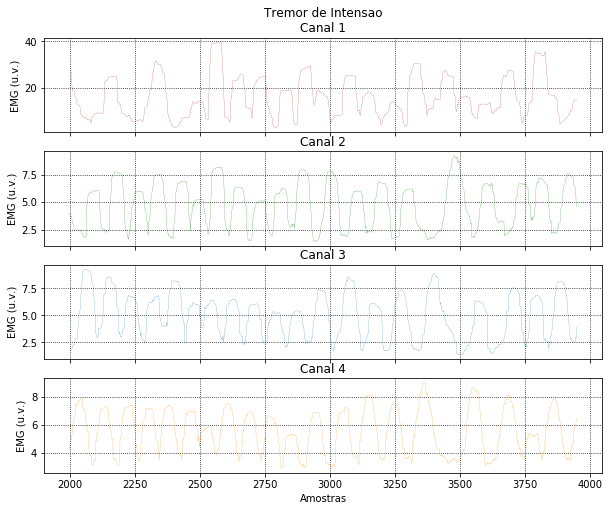

In [20]:
PlotFile(dfn)

In [21]:
for i in files:
    c = np.load('preproc/'+i[:-4]+'_std.npy')
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    Xc = df.copy()
    Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=2)
    Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=2)
    Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=2)
    Xc['Ch4'] = FilterSignal(df['Ch4'], low_pass=2)
    
    np.save('./preproc/'+i[:-4]+'_filt', Xc[:-49], allow_pickle=False)
    print i[:-4]+'_filt.npy'

pr09.2.3_filt.npy
prv06.3.2_filt.npy
piv17.3.2_filt.npy
pr17.2.2_filt.npy
prv09.3.2_filt.npy
pr17.1.2_filt.npy
piv09.2.2_filt.npy
piv09.2.3_filt.npy
pi17.1.3_filt.npy
pi09.1.3_filt.npy
pr17.2.3_filt.npy
pr06.1.3_filt.npy
pr07.1.3_filt.npy
pr09.1.3_filt.npy
pi09.1.2_filt.npy
prv17.3.2_filt.npy
piv09.2.1_filt.npy
piv07.3.3_filt.npy
prv07.2.3_filt.npy
prv09.3.3_filt.npy
pr17.1.3_filt.npy
prv17.3.3_filt.npy
piv07.3.1_filt.npy
prv07.2.2_filt.npy
piv06.2.3_filt.npy
pi07.2.3_filt.npy
pr06.2.2_filt.npy
prv09.3.1_filt.npy
pi06.1.3_filt.npy
piv06.2.1_filt.npy
piv17.3.1_filt.npy
pr09.2.1_filt.npy
pr07.1.1_filt.npy
prv06.3.1_filt.npy
piv17.3.3_filt.npy
prv06.3.3_filt.npy
pi07.2.2_filt.npy
pr09.2.2_filt.npy
prv17.3.1_filt.npy
pi06.1.2_filt.npy
piv07.3.2_filt.npy
pr07.1.2_filt.npy
pr06.2.1_filt.npy
pi09.1.1_filt.npy
pr17.1.1_filt.npy
pr06.1.1_filt.npy
pr06.1.2_filt.npy
pi17.1.2_filt.npy
pr09.1.1_filt.npy
piv06.2.2_filt.npy
pr06.2.3_filt.npy
pi17.1.1_filt.npy
pr17.2.1_filt.npy
pi06.1.1_filt.npy
prv07

In [22]:
df.head()

,Ch1,Ch2,Ch3,Ch4
0,0.013408,-0.002472,-0.037523,0.012262
1,0.056556,-0.002472,-0.041793,0.018771
2,-0.018952,0.001301,-0.037523,0.018771
3,0.002621,0.001301,-0.033254,-0.020279
4,0.013408,0.005073,-0.028985,-0.039803


In [23]:
c = np.load('preproc/pr17.2.1_filt.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,-0.088608,0.022326,0.001095,-0.002726
1,-0.041313,0.039175,0.001737,0.002177
2,-0.030150,0.026924,-0.000794,0.003362
3,-0.045403,0.011362,-0.003974,-0.007122
4,-0.057090,0.021684,-0.004451,-0.024212


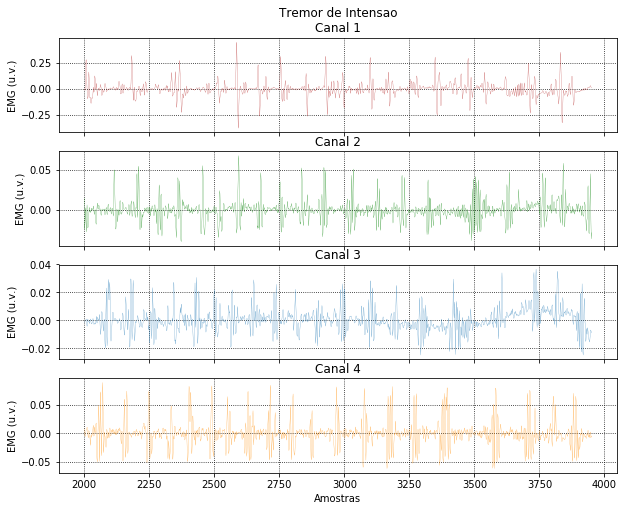

In [24]:
PlotFile(dfn)

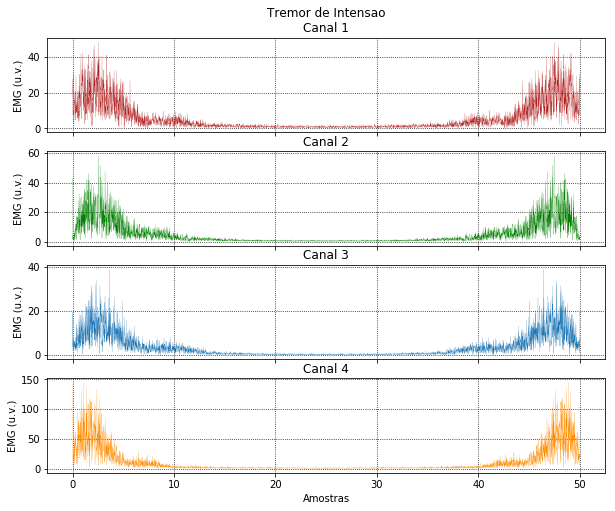

In [25]:
c = np.load('preproc/pi09.1.1_std.npy')
PlotFft(c, 50)

In [26]:
for i in files:
    c = np.load('preproc/'+i[:-4]+'_std.npy')
    #X = np.abs(np.fft.fft(Xc[:, 0]))
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    Xc = df.copy()
    Xc['Ch1'] = np.abs(np.fft.fft(df['Ch1']))
    Xc['Ch2'] = np.abs(np.fft.fft(df['Ch2']))
    Xc['Ch3'] = np.abs(np.fft.fft(df['Ch3']))
    Xc['Ch4'] = np.abs(np.fft.fft(df['Ch4']))

    np.save('./preproc/'+i[:-4]+'_fft', Xc[:-49], allow_pickle=False)
    print i[:-4]+'_fft.npy'

pr09.2.3_fft.npy
prv06.3.2_fft.npy
piv17.3.2_fft.npy
pr17.2.2_fft.npy
prv09.3.2_fft.npy
pr17.1.2_fft.npy
piv09.2.2_fft.npy
piv09.2.3_fft.npy
pi17.1.3_fft.npy
pi09.1.3_fft.npy
pr17.2.3_fft.npy
pr06.1.3_fft.npy
pr07.1.3_fft.npy
pr09.1.3_fft.npy
pi09.1.2_fft.npy
prv17.3.2_fft.npy
piv09.2.1_fft.npy
piv07.3.3_fft.npy
prv07.2.3_fft.npy
prv09.3.3_fft.npy
pr17.1.3_fft.npy
prv17.3.3_fft.npy
piv07.3.1_fft.npy
prv07.2.2_fft.npy
piv06.2.3_fft.npy
pi07.2.3_fft.npy
pr06.2.2_fft.npy
prv09.3.1_fft.npy
pi06.1.3_fft.npy
piv06.2.1_fft.npy
piv17.3.1_fft.npy
pr09.2.1_fft.npy
pr07.1.1_fft.npy
prv06.3.1_fft.npy
piv17.3.3_fft.npy
prv06.3.3_fft.npy
pi07.2.2_fft.npy
pr09.2.2_fft.npy
prv17.3.1_fft.npy
pi06.1.2_fft.npy
piv07.3.2_fft.npy
pr07.1.2_fft.npy
pr06.2.1_fft.npy
pi09.1.1_fft.npy
pr17.1.1_fft.npy
pr06.1.1_fft.npy
pr06.1.2_fft.npy
pi17.1.2_fft.npy
pr09.1.1_fft.npy
piv06.2.2_fft.npy
pr06.2.3_fft.npy
pi17.1.1_fft.npy
pr17.2.1_fft.npy
pi06.1.1_fft.npy
prv07.2.1_fft.npy
pi07.2.1_fft.npy
pr09.1.2_fft.npy


## Transformada de Wavelet

for i in files:
    c = np.load('preproc/'+i[:-4]+'_std.npy')
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    XcA = df.copy()
    
    cA, cD = pywt.dwt(XcA['Ch1'], 'db1', 'smooth')
    c = np.hstack((cA.reshape(cA.shape),cD.reshape(cD.shape)))
    XcA['Ch1'] = c
    
    cA, cD = pywt.dwt(XcA['Ch2'], 'db1', 'smooth')
    c = np.hstack((cA.reshape(cA.shape),cD.reshape(cD.shape)))
    XcA['Ch2'] = c
    
    cA, cD = pywt.dwt(XcA['Ch3'], 'db1', 'smooth')
    c = np.hstack((cA.reshape(cA.shape),cD.reshape(cD.shape)))
    XcA['Ch3'] = c
    
    cA, cD = pywt.dwt(XcA['Ch4'], 'db1', 'smooth')
    c = np.hstack((cA.reshape(cA.shape),cD.reshape(cD.shape)))
    XcA['Ch4'] = c
    
    np.save('./preproc/'+i[:-4]+'_wlt', XcA[:-49], allow_pickle=False)
    print i[:-4]+'_wlt.npy'

## PeakUtils testes

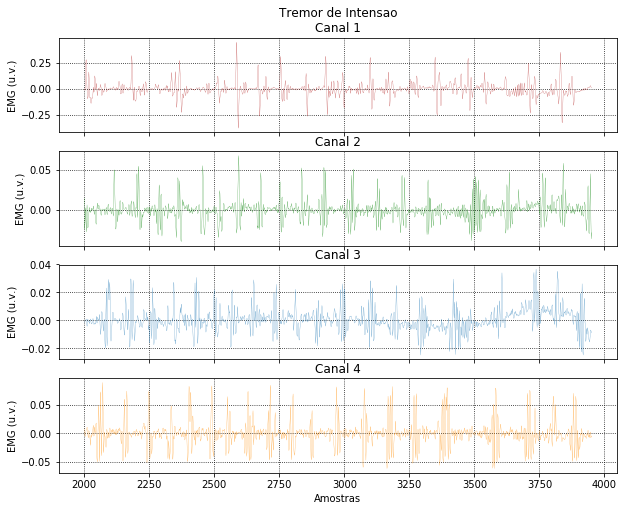

In [27]:
c = np.load('preproc/pr17.1.1_std.npy')
PlotFile(dfn)

In [26]:
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot

In [225]:
for i in files:
    c = np.load('preproc/'+i[:-4]+'_std.npy')
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    Xc = df.copy()

    for values in df.columns.values:

        y = Xc[values][:2000].values
        #thres = np.round((abs(min(y))+np.mean(abs(y)))/(abs(min(y))+max(y)),3) + 0.35
        thres = np.round((np.mean(abs(y)))/(abs(min(y))+max(y)),3) + 0.35
        peaks = peakutils.indexes(y, thres=thres, min_dist=1)
        Xc[values] = (np.ones(len(df))*len(peaks)).reshape((len(df),1))
    
    np.save('./preproc/'+i[:-4]+'_peaks', Xc[:-49], allow_pickle=False)
    print i[:-4]+'_peaks.npy'

pd06.1.1_peaks.npy
pd06.1.2_peaks.npy
pd06.1.3_peaks.npy
pd07.1.1_peaks.npy
pd07.1.2_peaks.npy
pd07.1.3_peaks.npy
pd09.2.1_peaks.npy
pd09.2.2_peaks.npy
pd09.2.3_peaks.npy
pd17.2.1_peaks.npy
pd17.2.2_peaks.npy
pd17.2.3_peaks.npy
pdv06.2.1_peaks.npy
pdv06.2.2_peaks.npy
pdv06.2.3_peaks.npy
pdv07.2.1_peaks.npy
pdv07.2.2_peaks.npy
pdv07.2.3_peaks.npy
pdv09.3.1_peaks.npy
pdv09.3.2_peaks.npy
pdv09.3.3_peaks.npy
pdv17.3.1_peaks.npy
pdv17.3.2_peaks.npy
pdv17.3.3_peaks.npy
pe06.1.1_peaks.npy
pe06.1.2_peaks.npy
pe06.1.3_peaks.npy
pe07.1.1_peaks.npy
pe07.1.2_peaks.npy
pe07.1.3_peaks.npy
pe09.2.1_peaks.npy
pe09.2.2_peaks.npy
pe09.2.3_peaks.npy
pe17.2.1_peaks.npy
pe17.2.2_peaks.npy
pe17.2.3_peaks.npy
pev06.2.1_peaks.npy
pev06.2.2_peaks.npy
pev06.2.3_peaks.npy
pev07.2.1_peaks.npy
pev07.2.2_peaks.npy
pev07.2.3_peaks.npy
pev09.3.1_peaks.npy
pev09.3.2_peaks.npy
pev09.3.3_peaks.npy
pev17.3.1_peaks.npy
pev17.3.2_peaks.npy
pev17.3.3_peaks.npy
pi06.1.1_peaks.npy
pi06.1.2_peaks.npy
pi06.1.3_peaks.npy
pi07.2.

In [226]:
c = c = np.load('preproc/pr06.1.1_std.npy')
y = c[:2000,3]
x = fs = np.linspace(0, 1,y.shape[0])
thres = np.round((np.mean(abs(y)))/(abs(min(y))+max(y)),3) + 0.35


In [227]:
thres

0.695

<IPython.core.display.Javascript object>


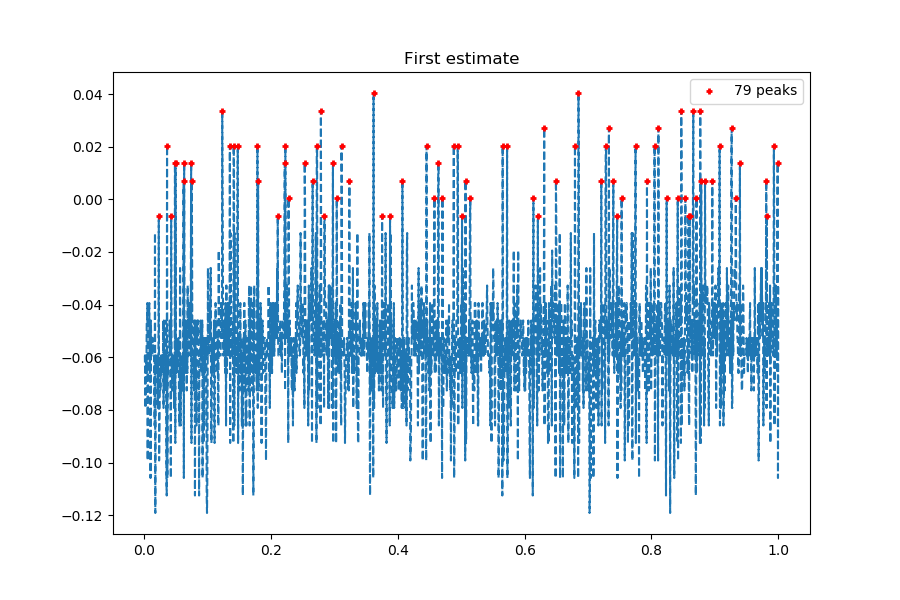

Text(0.5,1,u'First estimate')

In [228]:
peaks = peakutils.indexes(y, thres=thres, min_dist=1)
%matplotlib notebook
pyplot.figure(figsize=(9,6))
pplot(x, y, peaks)
pyplot.title('First estimate')

In [51]:
np.mean(abs(y))

0.0051612594017640115

In [52]:
np.mean([i for i in y if i > 0])

0.005022837119521031

In [68]:
np.round((abs(min(y))+np.mean(abs(y)))/(abs(min(y))+max(y)),3)

0.454

In [112]:
len([i for i in y if i > 0])

3370

In [153]:
files[0]-4

'pd06.1.1.npy'

In [158]:
if platform == "linux" or platform == "linux2":
    files = os.listdir('db/partitioned')
elif platform == "win32":
    files = os.listdir('C:\Users\jorge.junior\Documents\GitHub\PKS\db\partitioned')
    
files_ = []
for i in files:
    files_.append([i[:-4]+'_filt.npy',i[:-4]+'_rms.npy',i[:-4]+'_fft.npy',i[:-4]+'_peaks.npy',i[:-4]+'_std.npy'])

In [159]:
files_

[['pd06.1.1_filt.npy',
  'pd06.1.1_rms.npy',
  'pd06.1.1_fft.npy',
  'pd06.1.1_peaks.npy',
  'pd06.1.1_std.npy'],
 ['pd06.1.2_filt.npy',
  'pd06.1.2_rms.npy',
  'pd06.1.2_fft.npy',
  'pd06.1.2_peaks.npy',
  'pd06.1.2_std.npy'],
 ['pd06.1.3_filt.npy',
  'pd06.1.3_rms.npy',
  'pd06.1.3_fft.npy',
  'pd06.1.3_peaks.npy',
  'pd06.1.3_std.npy'],
 ['pd07.1.1_filt.npy',
  'pd07.1.1_rms.npy',
  'pd07.1.1_fft.npy',
  'pd07.1.1_peaks.npy',
  'pd07.1.1_std.npy'],
 ['pd07.1.2_filt.npy',
  'pd07.1.2_rms.npy',
  'pd07.1.2_fft.npy',
  'pd07.1.2_peaks.npy',
  'pd07.1.2_std.npy'],
 ['pd07.1.3_filt.npy',
  'pd07.1.3_rms.npy',
  'pd07.1.3_fft.npy',
  'pd07.1.3_peaks.npy',
  'pd07.1.3_std.npy'],
 ['pd09.2.1_filt.npy',
  'pd09.2.1_rms.npy',
  'pd09.2.1_fft.npy',
  'pd09.2.1_peaks.npy',
  'pd09.2.1_std.npy'],
 ['pd09.2.2_filt.npy',
  'pd09.2.2_rms.npy',
  'pd09.2.2_fft.npy',
  'pd09.2.2_peaks.npy',
  'pd09.2.2_std.npy'],
 ['pd09.2.3_filt.npy',
  'pd09.2.3_rms.npy',
  'pd09.2.3_fft.npy',
  'pd09.2.3_peaks.npy

In [165]:
len(files_[0])-1

4